In [ ]:
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



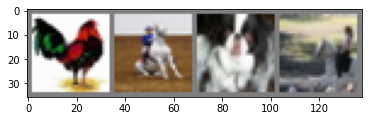

bird  horse dog   horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [23]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# ResNet

# **SKIP CONNECTIONS**
* Deep neural networks are difficult to train, and one major problem they suffer from is vanishing-gradients(or exploding-gradients as well). The absolute value of the Gradient signal tends to decrease exponentially as we move from the last layer to the first, which makes the gradient descent process extremely slow
*   Introducing ResNet blocks with "skip-connections" in very deep neural nets helps us address the problem of vanishing-gradients and also accounts for an ease-of-learning in very deep NNs. The intuition behind why this works is that a residual-network block with a skip-connection can learn the identity function (capable of outputting its input as it is). So adding the residual block to the network poses little risk to the learning performance of the network

# **IDENTITY BLOCK**
A block of layers with skip connection, where the input activation (say *a[i]*) has the same dimension as the output activation (say *a[i+n]* where n is number of layers in the block) is an identity block in a ResNet.

**Structure of the identity block**

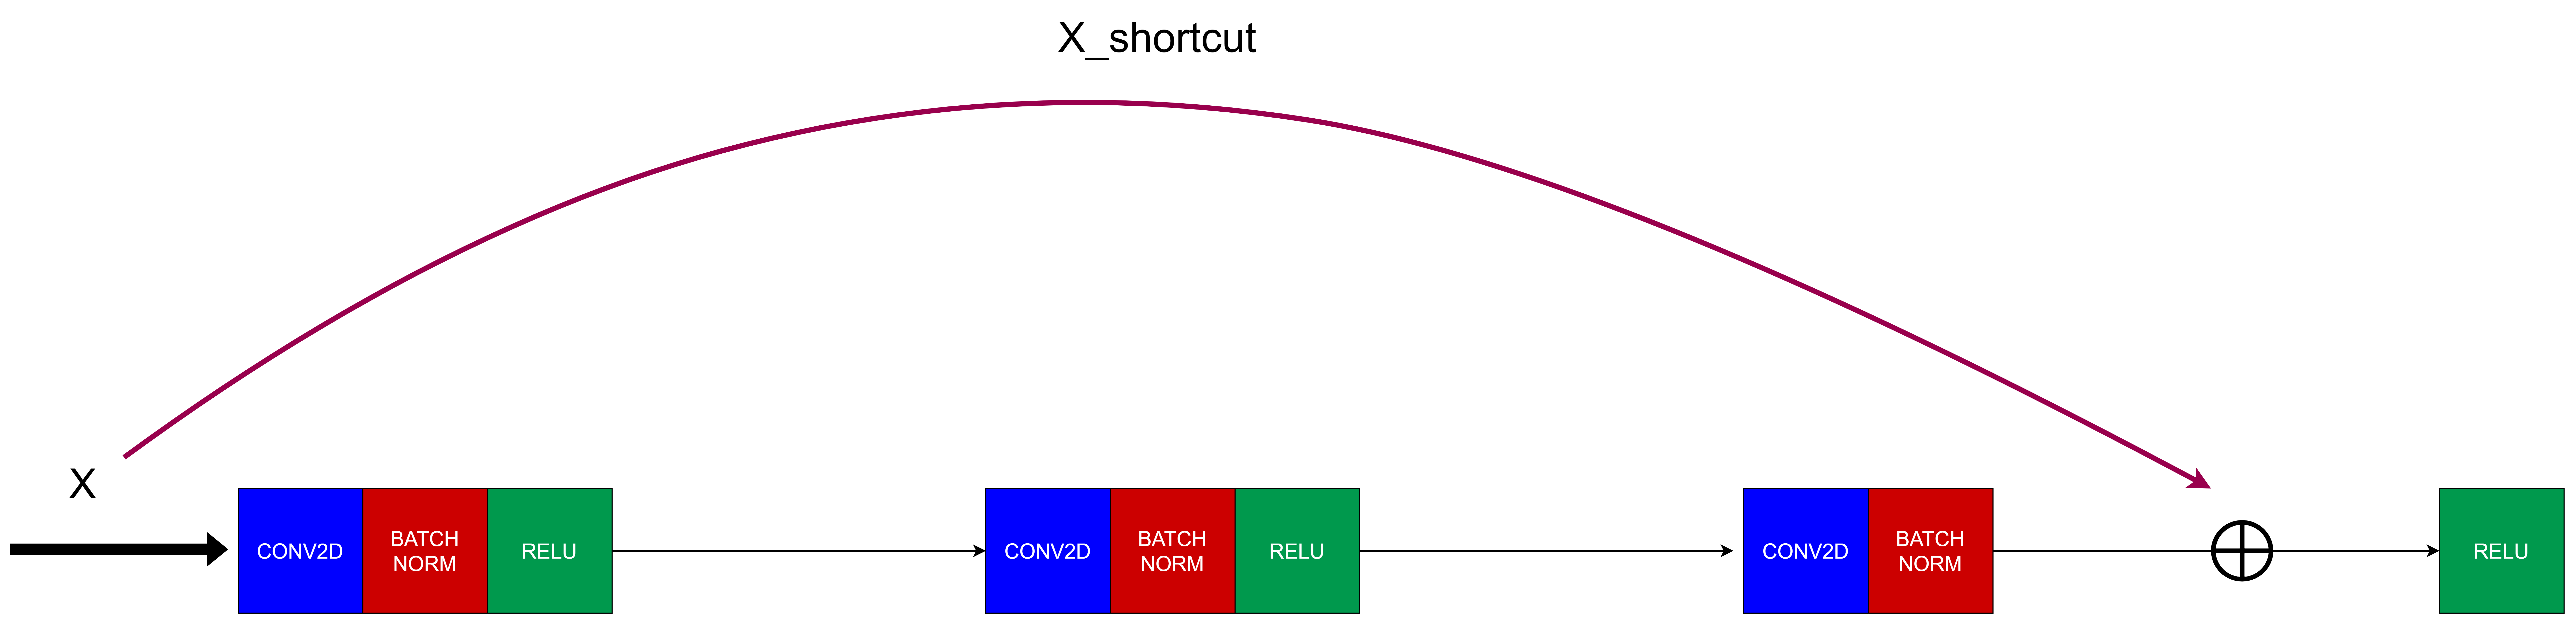

In [16]:
# net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
# model_ft = net
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 10)

In [18]:
# net = model_ft

In [19]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)

cuda:0


In [20]:
# net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [24]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.306
[1,  4000] loss: 2.305
[1,  6000] loss: 2.305
[1,  8000] loss: 2.306
[1, 10000] loss: 2.307
[1, 12000] loss: 2.306
[2,  2000] loss: 2.306
[2,  4000] loss: 2.307
[2,  6000] loss: 2.306
[2,  8000] loss: 2.305
[2, 10000] loss: 2.304
[2, 12000] loss: 2.306
Finished Training


Let's quickly save our trained model:



In [25]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [26]:
# net1 = Net()
# net1.load_state_dict(torch.load(PATH))

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



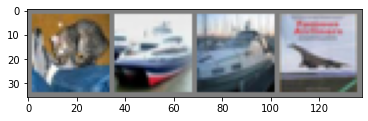

GroundTruth:  cat   ship  ship  plane


In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [28]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [29]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



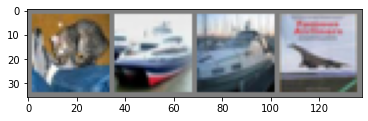

Predicted:  deer  deer  car   car  


In [30]:
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 7 %


In [32]:
print(total)

10000


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 41.1 %
Accuracy for class: bird  is 0.1 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 32.3 %
Accuracy for class: dog   is 0.4 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


<h2> Analysis </h2> 

We train the model for more number of iterations, say 20 and save it. Next, we analyze the model. 
<br> <br> 
How is the model really performing? We evaluate the model on various performance metrics so that we can determine whether the model has generalized and is performing well on unseen data? 
<br> <br> 



In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_net_trained_20.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net_trained = Net()
net_trained.load_state_dict(torch.load('./cifar_net_trained_20.pth'))

We look at the following metrics - 


*  Accuracy 
*  Recall 
*  Precision 
* F1 score 
* Confusion Matrix 


<h3> Accuracy </h3>
Accuracy simply measures how often the classifier correctly predicts. We can define accuracy as the ratio of the number of correct predictions and the total number of predictions.


In [36]:
!pip install torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 36.6 MB/s eta 0:00:00


In [ ]:
l = []
pred = []
out = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        l = l + labels.tolist()
        pred = pred + predictions.tolist()
        out = out + outputs.tolist()


In [ ]:
labels =torch.tensor(l)
predictions =torch.tensor(pred)
output = torch.tensor(out)

In [ ]:
import torchmetrics
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
acc = accuracy(predictions, labels)
print("The accuracy of the model is : ", acc.item() * 100, "%") 

The accuracy of the model is :  60.610002279281616 %


<h3> Recall </h3>
Recall explains how many of the actual positive cases we were able to predict correctly with our model. It is a useful metric in cases where False Negative is of higher concern than False Positive. It is important in medical cases where it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected!

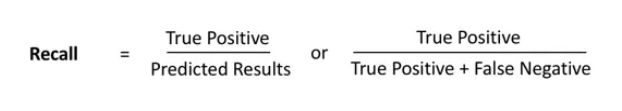

The difference between macro and micro averaging is that macro averaging gives equal weight to each category while micro averaging gives equal weight to each sample. 
<br><br>
If we have the same number of samples for each class, both macro and micro will provide the same score.

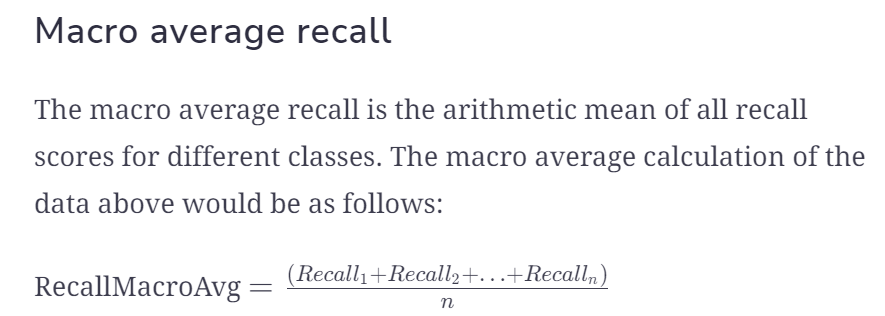

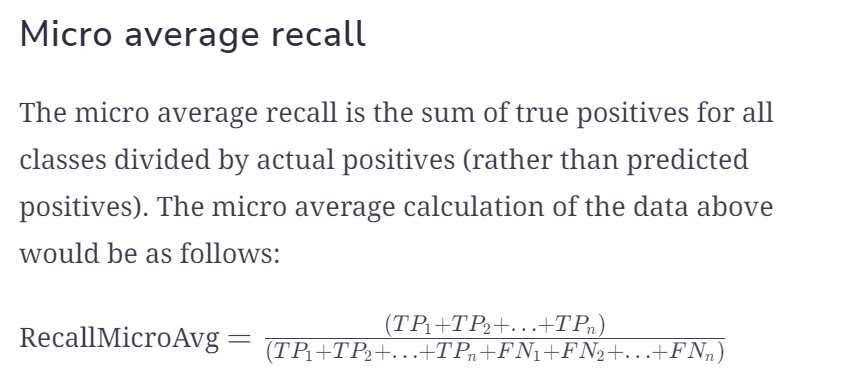

In [ ]:
Recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=10)
re = Recall(predictions, labels)
print("The recall of the model is : ", re.item()) 

Recall = torchmetrics.Recall(task="multiclass", average='micro', num_classes=10)
re = Recall(predictions, labels)
print("The recall of the model is : ", re.item()) 

The recall of the model is :  0.6060999631881714
The recall of the model is :  0.6061000227928162


<h3> Precision </h3>

Precision explains how many of the correctly predicted cases actually turned out to be positive. Precision is useful in the cases where False Positive is a higher concern than False Negatives. The importance of Precision is in music or video recommendation systems, e-commerce websites, etc. where wrong results could lead to customer churn and this could be harmful to the business.

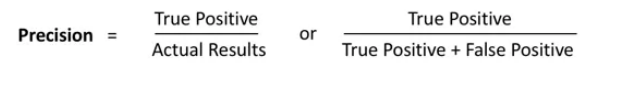

<h3> Macro Precision </h3> 
We calculate the precision for each class separately in an One vs All way. And then take the the average of all precision values.


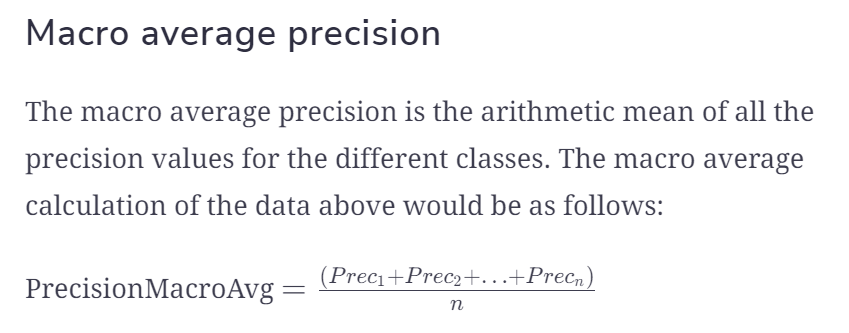

Micro Averaged Precision: Here we calculate the TP and FP for each class, and then calculate the overall Precision

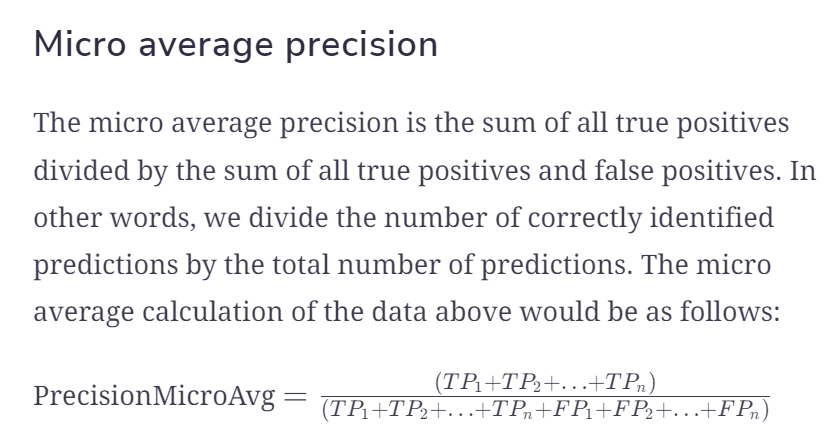

In [ ]:
Precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=10)
p = Precision(predictions, labels)
print("The Precision of the model is : ", p.item()) 

Precision = torchmetrics.Precision(task="multiclass", average='micro', num_classes=10)
p = Precision(predictions, labels)
print("The Precision of the model is : ", p.item()) 

The Precision of the model is :  0.6123978495597839
The Precision of the model is :  0.6061000227928162


<h3> F1 score </h3>
 It gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.

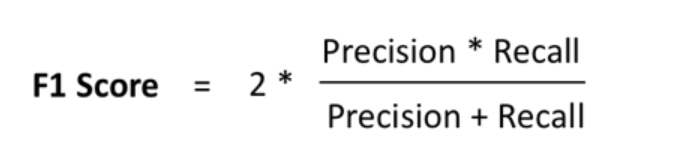

In [ ]:
f1 = torchmetrics.F1Score(task="multiclass", num_classes=10)
f = f1(predictions, labels)
print("The F1 score of the model is : ", f.item()) 

The F1 score of the model is :  0.6061000227928162


<h3> Confusion Matrix </h3>
Confusion Matrix is a performance measurement for the machine learning classification problems where the output can be two or more classes. It is a table with combinations of predicted and actual values.

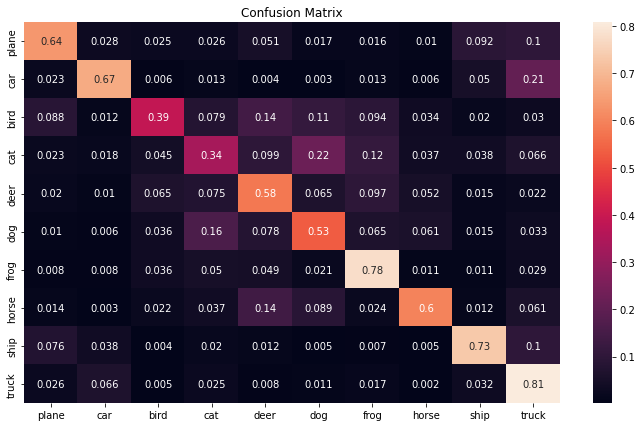

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# images, labels = data
# outputs = net(images)
# _, predictions = torch.max(outputs, 1)
cf_matrix = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix')
plt.xlabel('Ground Truths')
plt.ylabel('Predicted Values')
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
del dataiter

In [ ]:
# add here
# Analysis: precision, recall, f1-score, confusion matrix, ROC curve
